#####################################################################################################################
## Credit: this demo code is a modified version of the following notebook: https://www.kaggle.com/code/nilaychauhan/fine-tune-gemma-models-in-keras-using-lora
#####################################################################################################################

In [1]:
#! pip install matplotlib
#! pip install scikit-learn
#! pip install -U -q keras-hub
#! pip install -U -q keras>=3

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import keras
import keras_nlp
import json
import numpy as np
import time
import sacrebleu
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
from IPython.display import Markdown

2024-12-03 00:42:21.409070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 00:42:22.633492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 00:42:22.965422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 00:42:58.453224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/mnt/ceph/users/shassan/llms/myvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook 

### Define hyper parameters and helper functions

In [3]:
token_limit =128
lora_rank = 8
lr_value = 5e-5
train_epoch = 5
batch_size = 4
weight_decay = 0.01
model_id = "gemma2_instruct_2b_en" 


start_of_turn_user = "<start_of_turn>user\n"
start_of_turn_model = "<start_of_turn>model\n"
end_of_turn = "<end_of_turn>\n"


# helper functions to get answer from model
def get_answer_from_model(llm,input):
    prompt = start_of_turn_user + input + \
    end_of_turn + start_of_turn_model
    output = llm.generate(prompt, max_length=256)
    index  = output.index(start_of_turn_model) + len(start_of_turn_model)
    return output[index:-len(end_of_turn)]
    
# helper functions to get question, and answer from full prompt 
def get_question_answer_from_prompt(input):
    index_as  = input.index(start_of_turn_model) + len(start_of_turn_model)
    answer    = input[index_as:-len(end_of_turn)]
    index_qs  = input.index(start_of_turn_model)-len(end_of_turn)
    question  = input[len(start_of_turn_user):index_qs]
    return question, answer

## Read finetuning and testing datasets, and split to test/validation sets.

In [4]:
## READ finetuning data
with open('arxiv_astrophco_qa_pairs_2018_2022_finetuning.json', 'r') as f:
  finetuning_data = json.load(f)

finetune_list = []
for i in range(len(finetuning_data)):
    instruction   = finetuning_data[i]['Question']
    response      = finetuning_data[i]['REF_ANS']
    tmp = start_of_turn_user + instruction + \
    end_of_turn + start_of_turn_model + response + \
    end_of_turn
    finetune_list.append(tmp)

## READ testing data
with open('arxiv_astrophco_qa_pairs_2023_testing.json', 'r') as f:
  testing_data = json.load(f)

testing_list = []
for i in range(len(testing_data)):
    instruction   = testing_data[i]['Question']
    response      = testing_data[i]['REF_ANS']
    tmp = start_of_turn_user + instruction + \
    end_of_turn + start_of_turn_model + response + \
    end_of_turn
    testing_list.append(tmp)


# Split testing data into 50% test and 50% validation data
#test_list, valid_list, _, _ = train_test_split(testing_list, testing_list, test_size=0.5, random_state=42)


#print ("finetune data size", len(finetune_list) ,"test data size", len(test_list), "valid data size", len(valid_list) )

## check some random samples

In [5]:
finetune_list[0]

'<start_of_turn>user\nWhat type of astrophysical objects are known to have the highest mass-to-light ratios in the Universe?<end_of_turn>\n<start_of_turn>model\nDwarf spheroidal galaxies<end_of_turn>\n'

In [6]:
testing_list[0]

'<start_of_turn>user\nCan the upcoming observations by a high-angular resolution experiment of CMB and deep galaxy imaging survey tightly constrain certain cosmological parameters?<end_of_turn>\n<start_of_turn>model\nYes, they can, with accuracies comparable to or even better than those of the stage-III type surveys neglecting the effect of massive neutrinos.<end_of_turn>\n'

## Load model and apply LORA

In [7]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()
# Limit the input sequence length (to control memory usage).                                                                                              
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).                                                                                                  
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=weight_decay,
)
# Exclude layernorm and bias terms from decay.                                                                                                            
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

2024-12-03 00:44:56.544782: W external/xla/xla/service/gpu/nvptx_compiler.cc:932] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-12-03 00:45:08.836479: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,620,199,168 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,620,199,168 (9.76 GB)

 Trainable params: 5,857,280 (22.34 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

## Start finetuning ....

In [8]:
history = gemma_lm.fit(finetune_list, epochs=train_epoch, batch_size=batch_size)

2024-12-03 00:45:10.141698: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Epoch 1/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 115s 98ms/step - loss: 1.3156 - sparse_categorical_accuracy: 0.4605
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 57s 53ms/step - loss: 0.7555 - sparse_categorical_accuracy: 0.5770
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 47s 54ms/step - loss: 0.6989 - sparse_categorical_accuracy: 0.6038
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 47s 54ms/step - loss: 0.6730 - sparse_categorical_accuracy: 0.6093
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 47s 54ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.6151


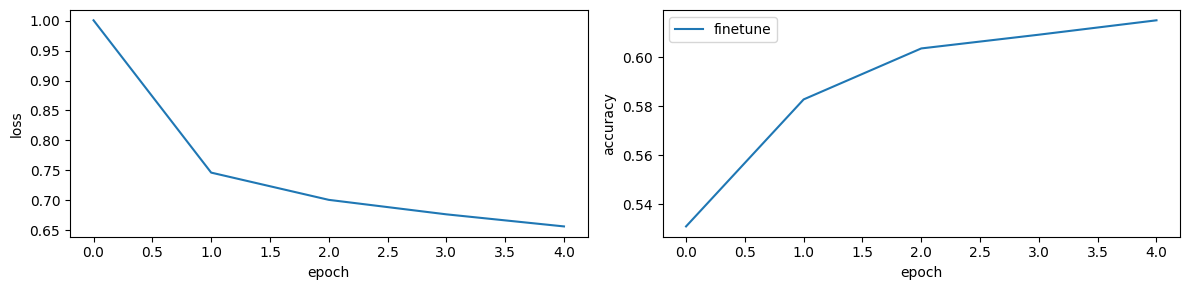

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(history.history['loss'], label='finetune')
ax[1].plot(history.history['sparse_categorical_accuracy'],label='finetune')
for i in range(2):
    ax[i].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Generate predictions from the fine-tuned model for the testing set.

In [ ]:
pred_ANS = []
for i in range(len(testing_list)):
    Question, REF_ANS =  get_question_answer_from_prompt(testing_list[i])
    print ("###################################", i)
    print ("Question:", Question + '\n')
    print ("REF_ANS:", REF_ANS + '\n')
    output = get_answer_from_model(gemma_lm, Question)
    print ("PRED_ANS:", output + '\n')
    pred_ANS.append(output)

################################### 0
Question: Can the upcoming observations by a high-angular resolution experiment of CMB and deep galaxy imaging survey tightly constrain certain cosmological parameters?

REF_ANS: Yes, they can, with accuracies comparable to or even better than those of the stage-III type surveys neglecting the effect of massive neutrinos.

PRED_ANS: Yes, it can.

################################### 1
Question: Do relativistic corrections to cosmic shear bispectrum overlap with local type non-Gaussianity?

REF_ANS: Yes, they can contaminate the search for a primordial local signal by f_NL>10.

PRED_ANS: Yes, they do.

################################### 2
Question: Do observational quantities show a distortion compared to theoretical predictions?

REF_ANS: Yes, they do increase with higher redshift values.

PRED_ANS: Yes, they do.

################################### 3
Question: What is the typical age of large-scale stellar disks in S0 galaxies that reside in dense

In [ ]:
# save files.
with open("qa_pairs_testing.json", "w") as f:
    json.dump(pred_ANS, f) 